# Instructions

## Environment setup

- Install [anaconda](https://docs.anaconda.com/anaconda/install/) and [SUMO](https://www.eclipse.org/sumo/), following the install instructions
- !NOTE!: SUMO-Python integration works best with Linux and Windows systems. MacOS can be used, but will require additional effort (Homebrew, custom env variables).
- Add SUMO to your system environment path (for windows: this will be asked by the installer. For linux, be sure to export the SUMO_HOME environment variable pointing to the appropriate folder)
- Use getting started resources that we provided to get familiar with some of the functionalities of this python wrapper.

## Assignment submission
- Add your code when there is the comment "YOUR CODE HERE"
- Use Markdown cells to provide your answers (when applicable)
- Make appropriate comments to your code
- Run the entire notebook and save it as a pdf. 
- Submit both the ipynb file and pdf file through email.
- Feel free to contact if you have any questions.


# Assignment

<p> In this assignment you will interact with the SUMO simulation, by setting up some traffic management logic. </p>
<p> Specifically, you will work with ramp metering. You are given a simple motorway network, as shown in the Figure:</p>
<img src='network.png'>
<p> This motorway has a lot of traffic demand, much like real life. The objective of ramp metering is to buffer some vehicles on the onramp of the motorway, regulating the inflow of new vehicles and therefore avoiding issues related with weaving maneuvers from oncoming traffic. </p>

<p> Your objective in this assignment is to implement a reactive control algorithm, that, considering current information on the density of vehicles collected from the sensor and past information on the algorithm's target flow, decides how many vehicles/hour are allowed on the motorway every 60 seconds. </p>

<p> We provide the implementation of no-control scenario and a simple on-off traffic management scenario </p>


### Importing functions and packages

In [82]:
import helpers as fu
import control_helpers as ch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from models import *

import os
import json
import pickle

## Baselines

### Running the base, no-control scenario

<p> Evaluate the situation on the motorway without any traffic management, based on the simulation and the resulting space-time diagram. </p>

In [81]:
# I change the code to simulate no-control scenario to collect the data of No-Control simulation
"""
df, df_veh = fu.run_base(gui=False) #Set gui=False if you don't want to see the graphical interface
len_E2_0 = 175.43
len_EWeave = 77.76
intersec_len = 0
# All lanes except EWeave_1
lane_list = ['E2_0', 'E2_1', 'E3_0', 'E3_1', 'EWeave_1', 'EWeave_2']
e3_list = ['E3_0', 'E3_1']
eweave_list = ['EWeave_1', 'EWeave_2']

df_veh = df_veh[df_veh['lane'].isin(lane_list)].copy()

# Add correct X location
for lane in eweave_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0
for lane in e3_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0 + len_EWeave

df_veh.speed = df_veh.speed.astype(float)
df_veh.time = df_veh.time.astype(float)
df_veh.pos = df_veh.pos.astype(float)
dat = df_veh[['time', 'pos', 'speed']]

# Plot the diagram for all the lanes
plt.scatter(x='time', y='pos', c=dat['speed'], cmap='YlOrRd', data=dat, s=1)
plt.colorbar(label='Speed')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title("Space-Time Diagram")
plt.show()
"""

'\ndf, df_veh = fu.run_base(gui=False) #Set gui=False if you don\'t want to see the graphical interface\nlen_E2_0 = 175.43\nlen_EWeave = 77.76\nintersec_len = 0\n# All lanes except EWeave_1\nlane_list = [\'E2_0\', \'E2_1\', \'E3_0\', \'E3_1\', \'EWeave_1\', \'EWeave_2\']\ne3_list = [\'E3_0\', \'E3_1\']\neweave_list = [\'EWeave_1\', \'EWeave_2\']\n\ndf_veh = df_veh[df_veh[\'lane\'].isin(lane_list)].copy()\n\n# Add correct X location\nfor lane in eweave_list:\n    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0\nfor lane in e3_list:\n    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0 + len_EWeave\n\ndf_veh.speed = df_veh.speed.astype(float)\ndf_veh.time = df_veh.time.astype(float)\ndf_veh.pos = df_veh.pos.astype(float)\ndat = df_veh[[\'time\', \'pos\', \'speed\']]\n\n# Plot the diagram for all the lanes\nplt.scatter(x=\'time\', y=\'pos\', c=dat[\'speed\'], cmap=\'YlOrRd\', data=dat, s=1)\nplt.colorbar(label=\'Speed\')\nplt.

### No Control Simulation

In [83]:
def no_control(density, previous_target_flow, policy=None):
    """set the target flow to the capacity of the ramp"""
    capacity = 1800
    target_flow = capacity
    return (target_flow, 0, 0)

In [86]:
densities_no, saved_log_probs, _ = ch.run(no_control, verbose=False) #You can also run the simulation with additional output, helping you figure out what your controller is doing: ch.run(on_off,verbose=True)
flows_episode = [estimate_flow(d) for d in densities_no] #estimated flow
df, df_veh = fu.read_output()

 Retrying in 1 seconds


Step #2120.00 (1ms ~= 1000.00*RT, ~0.00UPS, TraCI: 2ms, vehicles TOT 1726 ACT 0 BUF 0)    


In [87]:
print("Average flow: {:.4f}".format(np.mean(flows_episode)))
print("Average densities: {:.4f}".format(np.mean(densities_no)))

Average flow: 380.2718
Average densities: 67.1910


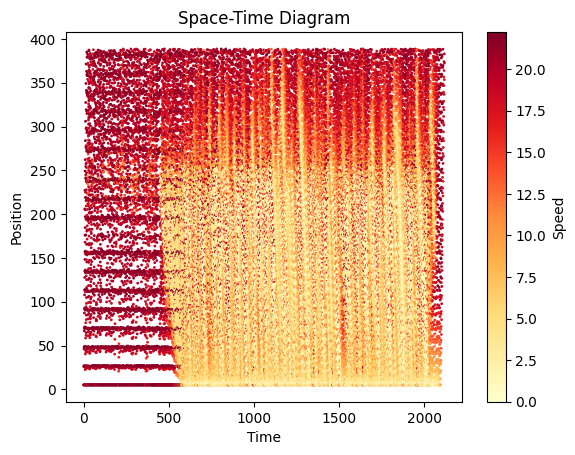

In [88]:
len_E2_0 = 175.43
len_EWeave = 77.76
intersec_len = 0
# All lanes except EWeave_1
lane_list = ['E2_0', 'E2_1', 'E3_0', 'E3_1', 'EWeave_1', 'EWeave_2']
e3_list = ['E3_0', 'E3_1']
eweave_list = ['EWeave_1', 'EWeave_2']

df_veh = df_veh[df_veh['lane'].isin(lane_list)].copy()

# Add correct X location
for lane in eweave_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0
for lane in e3_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0 + len_EWeave

df_veh.speed = df_veh.speed.astype(float)
df_veh.time = df_veh.time.astype(float)
df_veh.pos = df_veh.pos.astype(float)
dat = df_veh[['time', 'pos', 'speed']]

# Plot the diagram for all the lanes
plt.scatter(x='time', y='pos', c=dat['speed'], cmap='YlOrRd', data=dat, s=1)
plt.colorbar(label='Speed')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title("Space-Time Diagram")
plt.show()

In [89]:
print("Average Vehicle Speed: {:.4f}".format(df_veh.speed.mean()))

Average Vehicle Speed: 8.8215


<p> A typical way of evaluating a given traffic situation is through a so-called space-time diagram (also known as speed contour plots). What you see above is such an example. You can see that at time 500, speeds at position 250m begin decreasing. As the simulation progresses, this speed decrease propagates backwards in space (in the contour plot, the area showing reduced speed increases) - this means that the motorway is experiencing (excessive) queueing. Thanks to Ramp Metering, we can mitigate this queueing effect, as shown below. </p>

### Defining a simple on-off traffic management control function

In [90]:
def on_off(density, previous_target_flow, policy=None):
    """
    Simple on-off control policy:
    Given known values for the critical density of the motorway, and the capacity (saturation flow) of the onramp:
    if the density on the motorway is above critical, reduce inflow to 0
    if the density on the motorway is below critical, allow full inflow
    """
    target_density = 35
    capacity=1800
    if density > target_density:
        target_flow=0
    else:
        target_flow=capacity
        
    # Check max and min
    target_flow = min(target_flow,1800)
    target_flow= max(target_flow, 60)
    
    return (target_flow, 0, 0) #target flow, log_prob/action, state

#### Running the simulation with a given ramp metering algorithm

In [91]:
densities_onoff, saved_log_probs, _ = ch.run(on_off, verbose=False) #You can also run the simulation with additional output, helping you figure out what your controller is doing: ch.run(on_off,verbose=True)
flows_episode = [estimate_flow(d) for d in densities_onoff] #estimated flow
df, df_veh = fu.read_output()

 Retrying in 1 seconds


Step #2143.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 1726 ACT 0 BUF 0)                 


In [92]:
print("Average flow: {:.4f}".format(np.mean(flows_episode)))
print("Average densities: {:.4f}".format(np.mean(densities_onoff)))

Average flow: 753.5155
Average densities: 36.1899


### Exploring the results of the traffic management logic


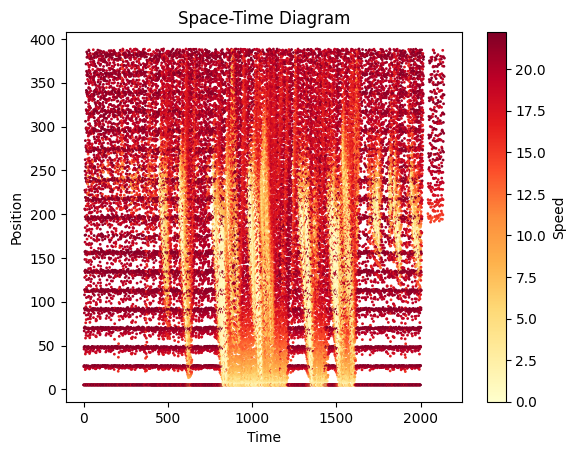

In [93]:
len_E2_0 = 175.43
len_EWeave = 77.76
intersec_len = 0
# All lanes except EWeave_1
lane_list = ['E2_0', 'E2_1', 'E3_0', 'E3_1', 'EWeave_1', 'EWeave_2']
e3_list = ['E3_0', 'E3_1']
eweave_list = ['EWeave_1', 'EWeave_2']
df_veh = df_veh[df_veh['lane'].isin(lane_list)].copy()

# Add correct X location
for lane in eweave_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0
for lane in e3_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0 + len_EWeave

df_veh.speed = df_veh.speed.astype(float)
df_veh.time = df_veh.time.astype(float)
df_veh.pos = df_veh.pos.astype(float)
dat = df_veh[['time', 'pos', 'speed']]

# Plot the diagram for all the lanes
plt.scatter(x='time', y='pos', c=dat['speed'], cmap='YlOrRd', data=dat, s=1)
plt.colorbar(label='Speed')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title("Space-Time Diagram")
plt.show()

<p>What you see above is how the on-off controller affected the formation of congestion in the motorway. Unfortunately, there is still quite a bit of queueing throughout the simulation period - the on-off controller is reducing the overall duration of congestion (the area of lowered speeds in the contour plot is smaller), however it's not adequately preventing congestion from forming. </p>

In [94]:
print("Average Vehicle Speed: {:.4f}".format(df_veh.speed.mean()))

Average Vehicle Speed: 14.4704


## Coding your own control logic

<p>In this assignment you are tasked with coding your own control logic, based on concepts of Reinforcement Learning. A template function for your control logic is provided below (based on the on-off controller above)</p>

<p>Compare qualitatively and quantitatively your proposed algorithm both to the no-control situation and to the simple on-off control logic provided above. </p>

<p> Suggested quantitative measures are: average flow on the motorway over time, average speed on the motorway over time, total vehicle delay. </p>

<p> Hint: copy the on-off controller logic, and change that function to your desired management approach!</p>

<p> Your analysis, chosen control logic (including a pseudo-code of its implementation) and findings should all be then summarised in the <b>jupyter notebook</b>, with all figures, explanations and justifications you deem necessary. </p>

<p> It is important for you to choose an appropriate reward function for your Reinforcement Learning controller to figure out the optimal policy to resolve this traffic management issue. You can begin by considering a reward function that depends on the density measured on the motorway, as well as the target density value. You may also come up with functions of more variables extracted from the simulation, however you will need to adapt the helper libraries in order to allow for more flexibility. </p?

## Methodology

### Model
<p>In this assignment, we used an MLP to map the state, i.e., the density on the main road, to the actions. The density features are transformed into 32-bit binary representations before being fed to the MLP. To simplify the action space, we use 19 actions: $a_0$ to $a_{18}$. The action $a_i$ denotes setting the target flow value to $100\times i$.</p>

<img src='dmlp.pdf'>

The code of the MLP model can be found at ```models.py```.

### Rewards
Our goal is to improve the average traffic flow on the main road by controlling the ramp meter. According to Greedshields' theory [[1]](#1), the traffic flow reaches the maximum when the density equals the critical density.
We apply the following equation to estimate the flow on the main road given density $\rho$, proposed by Arp et al [[2]](#2).

$f(\rho)=\frac{f_m}{\rho_c^2}max(0,\rho(2\rho_c-\rho))$, where $\rho_c$ is the critical density and $f_m$ is the maximal flow.

The reward is computed based on the estimated flow $f(\rho)$: $r=1-\frac{f_m-f(\rho)}{f_m}$.

In our experiments, the maximal flow is set to $1050$.

### Training
We use two RL methods to train the models: Deep Q-Learning (value-based) and Reinforce (policy-based). In Deep Q-Learning, the output of the MLP denotes the predicted Q values of each action. In Reinforce, the output denotes the probability distribution over the action space. We use each method to train the MLP for about 3500 episodes. The training codes can be found at ```train_deepQ.py``` and ```train_reinforce.py```. The trained models can be found in the folder ```trained```.

### Test trained models

In [95]:
# load the models
policy_Q = torch.load("trained/deepQ/policy.pt") # load Q policy
policy_reinforce = torch.load("trained/reinforce/policy.pt") # load reinforce policy

#read training log
df_Q = pd.read_csv("trained/deepQ/log.txt")
df_reinforce = pd.read_csv("trained/reinforce/log.txt")

#### Plot the training process
We plot the average scores of the last 100 episode during training. The score in each episode is defined as the average estimated traffic flow.

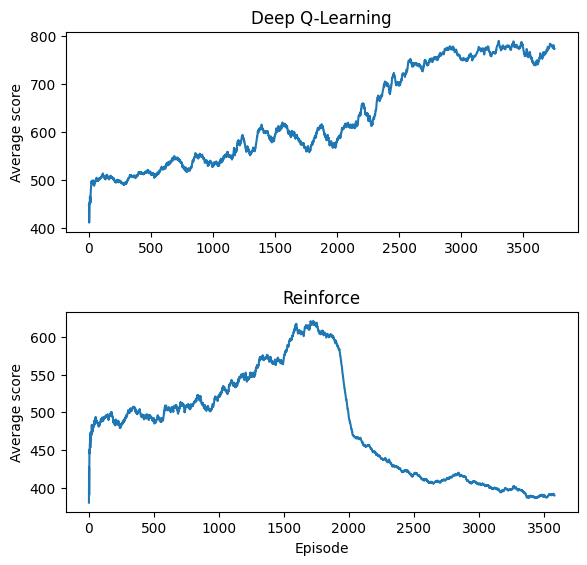

In [96]:
fig, axs = plt.subplots(2)
plt.xlabel("Episode")
axs[0].plot(df_Q.score_100_ave)
axs[0].set_title("Deep Q-Learning")
axs[0].set_ylabel("Average score")
axs[1].plot(df_reinforce.score_100_ave)
axs[1].set_title("Reinforce")
axs[1].set_ylabel("Average score")
fig.set_figheight(6)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

According to the above figure, the average score of Deep Q-Learning tends to improve during training. On the other hand, the average score of Reinforce stops improving after about 1700 episodes and starts decreasing. 

#### Deep Q Learning
Test the performance of the policy trained with deep Q-Learning.

In [97]:
def act_Q(state):
    """
    get action from Q-Learning Poicy
    """
    Q = policy_Q(state.float()).cpu()
    action = torch.argmax(Q)
    return action.item(), 0

def compute_target_flow_Q(density, previous_target_flow):
    """
    compute the target flow
    """
    density_bin = binary(density)
    state = torch.tensor(density_bin)
    action, log_prob = act_Q(state.unsqueeze(0))
    target_flow = action*100
    return target_flow, action, state #return the current state

<p> You may then run your simulation with the newly developed control logic and compare how the speed contour plot changes, similarly to what has been done above. </p>

In [98]:
densities_Q, actions, states = ch.run(compute_target_flow_Q, verbose=False) 
flows_episode = [estimate_flow(d) for d in densities_Q] #estimated flow
df, df_veh = fu.read_output()

 Retrying in 1 seconds


Step #2183.00 (0ms ?*RT. ?UPS, TraCI: 2ms, vehicles TOT 1726 ACT 0 BUF 0)                 


In [99]:
# get average estimated flow and average densities
print("Average flow: {:.4f}".format(np.mean(flows_episode)))
print("Average densities: {:.4f}".format(np.mean(densities_Q)))

Average flow: 896.7497
Average densities: 28.7599


Plot Space-Time Diagram of MLP (Deep Q-Learning)

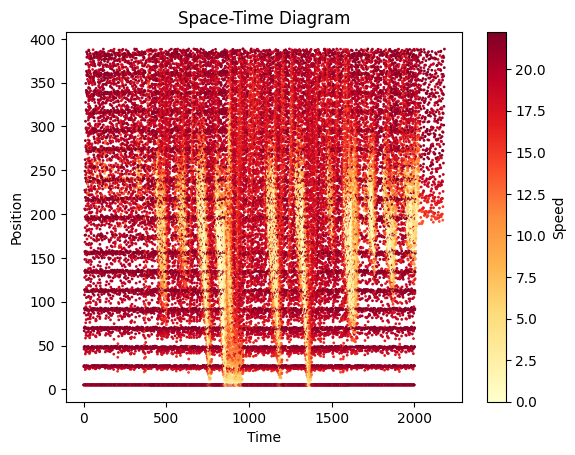

In [100]:
len_E2_0 = 175.43
len_EWeave = 77.76
intersec_len = 0
# All lanes except EWeave_1
lane_list = ['E2_0', 'E2_1', 'E3_0', 'E3_1', 'EWeave_1', 'EWeave_2']
e3_list = ['E3_0', 'E3_1']
eweave_list = ['EWeave_1', 'EWeave_2']
df_veh = df_veh[df_veh['lane'].isin(lane_list)].copy()

# Add correct X location
for lane in eweave_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0
for lane in e3_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0 + len_EWeave

df_veh.speed = df_veh.speed.astype(float)
df_veh.time = df_veh.time.astype(float)
df_veh.pos = df_veh.pos.astype(float)
dat = df_veh[['time', 'pos', 'speed']]

# Plot the diagram for all the lanes
plt.scatter(x='time', y='pos', c=dat['speed'], cmap='YlOrRd', data=dat, s=1)
plt.colorbar(label='Speed')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title("Space-Time Diagram")
plt.show()

In [101]:
#get average vehicle speed
print("Average Vehicle Speed: {:.4f}".format(df_veh.speed.mean()))

Average Vehicle Speed: 16.4438


#### reinforce
Test the performance of the policy trained with Reinforce.

In [102]:
def act_rein(state):
    """
    get action reinforce policy
    """
    probs = policy_reinforce(state.float()).cpu()
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

def compute_target_flow_rein(density, previous_target_flow):
    """
    compute the target flow
    """
    density_bin = binary(density)
    state = torch.tensor(density_bin)
    action, log_prob = act_rein(state.unsqueeze(0))
    target_flow = action*100
    return target_flow, log_prob, state #return the current state

In [105]:
densities_rein, actions, states = ch.run(compute_target_flow_rein, verbose=False) 
flows_episode = [estimate_flow(d) for d in densities_rein] #estimated flow
df, df_veh = fu.read_output()

 Retrying in 1 seconds


Step #2126.00 (0ms ?*RT. ?UPS, TraCI: 1ms, vehicles TOT 1726 ACT 0 BUF 0)                 


In [106]:
print("Average flow: {:.4f}".format(np.mean(flows_episode)))
print("Average densities: {:.4f}".format(np.mean(densities_rein)))

Average flow: 570.4621
Average densities: 50.5152


Plot Space-Time diagram of MLP (reinforce)

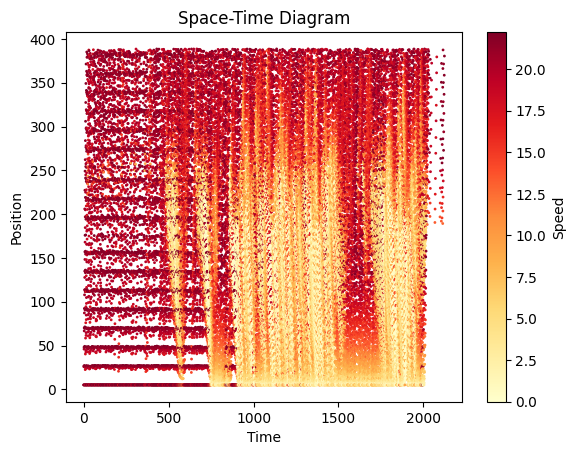

In [107]:
len_E2_0 = 175.43
len_EWeave = 77.76
intersec_len = 0
# All lanes except EWeave_1
lane_list = ['E2_0', 'E2_1', 'E3_0', 'E3_1', 'EWeave_1', 'EWeave_2']
e3_list = ['E3_0', 'E3_1']
eweave_list = ['EWeave_1', 'EWeave_2']
df_veh = df_veh[df_veh['lane'].isin(lane_list)].copy()

# Add correct X location
for lane in eweave_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0
for lane in e3_list:
    df_veh.loc[df_veh["lane"] == lane, "pos"] = df_veh.pos.astype(float) + len_E2_0 + len_EWeave

df_veh.speed = df_veh.speed.astype(float)
df_veh.time = df_veh.time.astype(float)
df_veh.pos = df_veh.pos.astype(float)
dat = df_veh[['time', 'pos', 'speed']]

# Plot the diagram for all the lanes
plt.scatter(x='time', y='pos', c=dat['speed'], cmap='YlOrRd', data=dat, s=1)
plt.colorbar(label='Speed')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title("Space-Time Diagram")
plt.show()

In [108]:
print("Average Vehicle Speed: {:.4f}".format(df_veh.speed.mean()))

Average Vehicle Speed: 10.8625


## Comparison & Discussion
We will compare MLP (Deep Q-Learning) and MLP (Reinforce) with the baselines No-Control and On-Off

### Space-Time Diagram
MLP (Deep Q-Learning) has a similar effect on reducing congestion compared with On-Off. However, the congestion reduction effect of MLP (reinforce) is not as good as On-Off.

### Average vehicle speed, estimated flow and densities
We summarize the average vehicle speed, estimated flow and densities in the following table.

| Method | Ave Speed | Ave Flow | Ave Density |
| ------ | --------- | -------- | ----------- |
| No-Control | 8.8215 | 380.2718 | 67.1910    |
| On-Off |   14.4704        |  753.5155 |  36.1899 |
| MLP (Deep Q) | **16.4438**    |  **896.7497** |  28.7599 |
| MLP (rein) |   10.8625    |  570.4627 |  50.5152 |

The method MLP trained with deep Q-Learning has highest speed and estimated flow. 

### Density Plotting
We plot the densities (states) of each step of one episode for the 4 methods. 

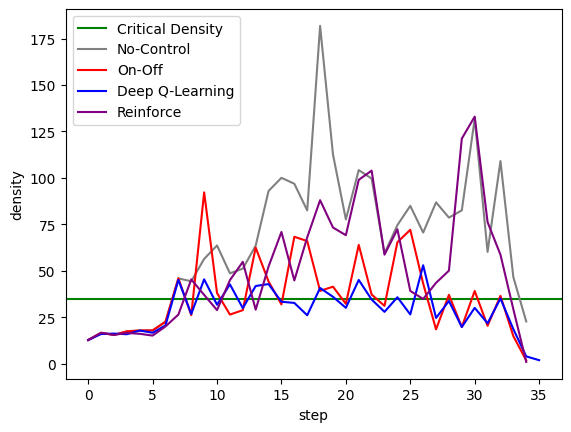

In [129]:
fig, ax = plt.subplots()
plt.axhline(y=35, color="green", label="Critical Density")
ax.plot(densities_no, color="grey", label="No-Control")
ax.plot(densities_onoff, color="red", label="On-Off")
ax.plot(densities_Q, color='blue', label="Deep Q-Learning")
ax.plot(densities_rein, color='purple', label="Reinforce")
ax.set_xlabel("step")
ax.set_ylabel("density")
plt.legend()

According to the above figure, we can find that the densities of the MLP (Deep Q-Learning) are more closed to the critical density during the episode compared with other methods.

## Future Works
- Analyze why the scores of MLP (Reinforce) stop after some episodes.
- Explore other policy-based RL algorithms, such as Actor-Critic, on this problem.
- Since the roads can be modelled as a network, it is worth studying how to combine Graph Neural Networks (GNN) with Reinforcement Learning to this problem.

## References

<a id="1">[1]</a>
Greenshields, B. D., Thompson, J. T., Dickinson, H. C., & Swinton, R. S. (1934). The photographic method of studying traffic behavior. In Highway Research Board Proceedings (Vol. 13).

<a id="2">[2]</a>
Arp, L., van Vreumingen, D., Gawehns, D., & Baratchi, M. (2020, June). Dynamic macro scale traffic flow optimisation using crowd-sourced urban movement data. In 2020 21st IEEE International Conference on Mobile Data Management (MDM) (pp. 168-177). IEEE.